# FFT musings
Just a simple notebook with plots to convince myself math is correct. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import obspy

## Zero Padding and ringing

In [3]:
st = obspy.read()
st.detrend('linear')
st.taper(max_percentage=.05)
data = st[0][:100]

fft1 = abs(np.fft.rfft(data))
freq1 = np.fft.rfftfreq(len(data), 100)

data2 = np.zeros(len(data) * 12)
data2[:len(data)] = data
fft2 = abs(np.fft.rfft(data2))
freq2 = np.fft.rfftfreq(len(data2), 100)


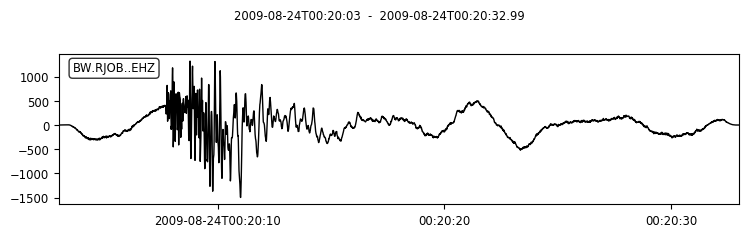

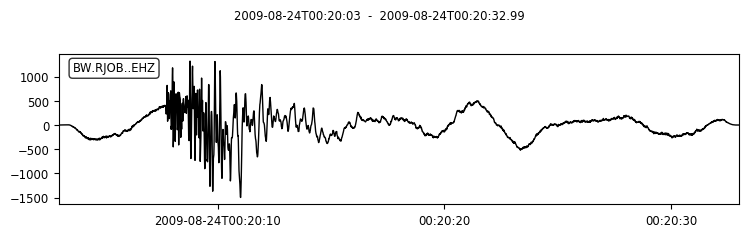

In [4]:
st[0].plot()

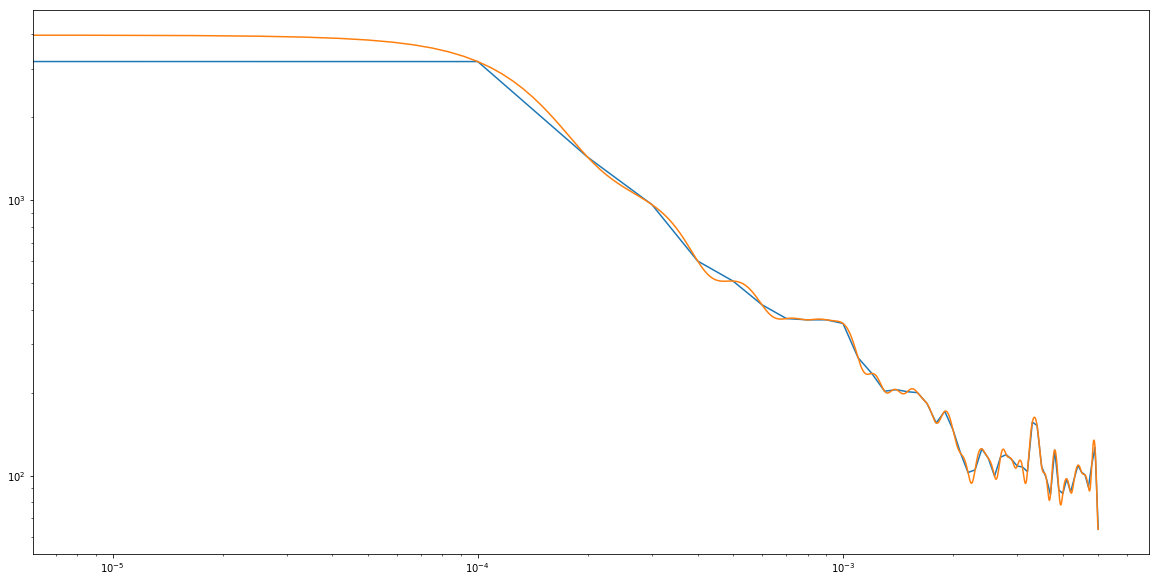

In [5]:
plt.figure(figsize=(20, 10))
plt.loglog(freq1, abs(fft1))
plt.loglog(freq2, abs(fft2))

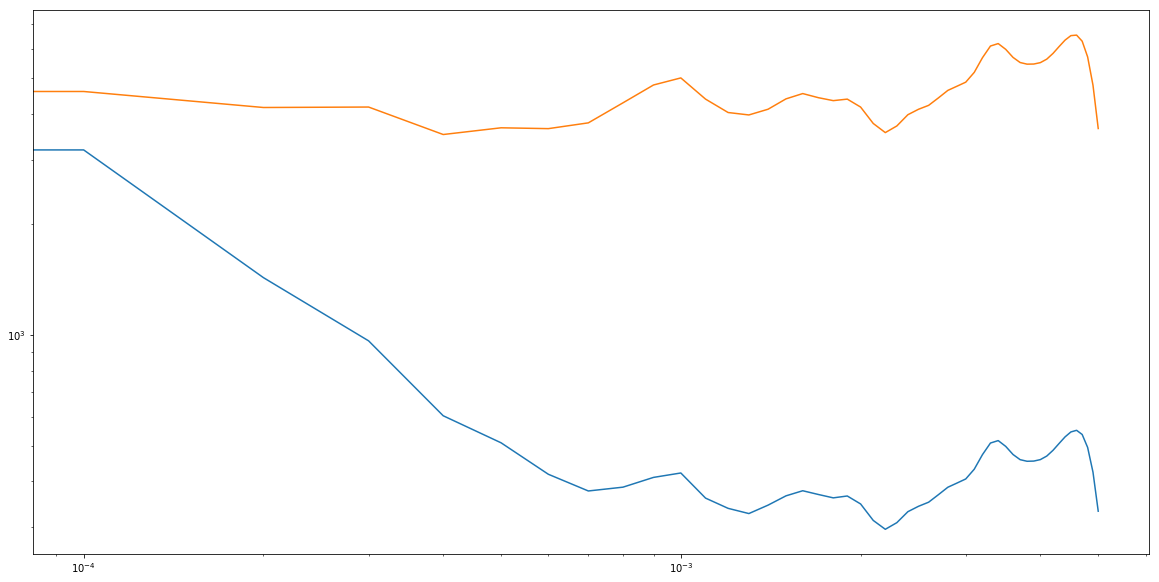

In [6]:
from mopy.smooth import konno_ohmachi_smoothing as ko_smooth

plt.figure(figsize=(20, 10))
sm1 = ko_smooth(fft1, freq1)
sm2 = ko_smooth(fft2, freq2, center_frequencies=freq1)
plt.loglog(freq1, sm1)
plt.loglog(freq1, sm2)

In [7]:
def plot_arrays(*, log=False, **kwargs):
    """ perform ffts on arrays and plot """
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    # first plot in time domain
    for label, array in kwargs.items():
        plt.plot(array, label=label, alpha=.5)
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.legend()
    
    # next plot freq
    plt.subplot(2,1,2)
    plot_func = plt.plot if not log else plt.loglog
    for label, array in kwargs.items():
        freqs = np.fft.rfftfreq(len(array), 1)
        fft = np.fft.rfft(array)
        plot_func(freqs, abs(fft), label=label, alpha=.5)
    plt.xlabel('frequency')
    plt.ylabel('amplitude')
    plt.legend()

Amplitude spectra of a few interesting alterations of a signal

In [8]:
tr = obspy.read()[0]
tr.detrend('linear')
tr.decimate(2)
# make original trace
ar1 = tr.data[225:700]

# make repeat trace
ar1_repeat = np.zeros(len(ar1) * 2)
ar1_repeat[:len(ar1)] = ar1
ar1_repeat[len(ar1):] = ar1
# zero paddded
ar1_zero_padded = np.zeros(len(ar1_repeat))
ar1_zero_padded[:len(ar1)] = ar1
# decimated
ar1_decimated = ar1[::2]
# double amp
ar1_2_amp = ar1 * 2

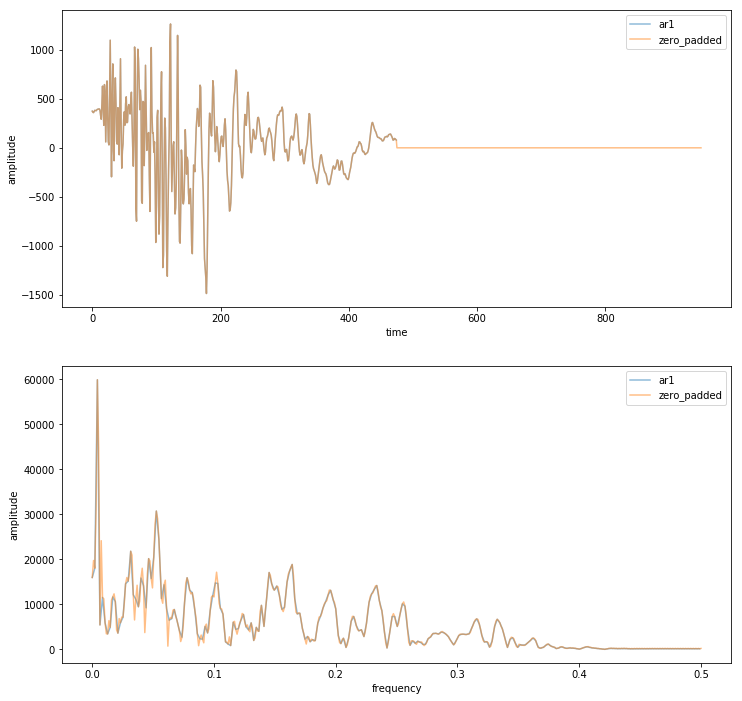

In [9]:
plot_arrays(ar1=ar1, # ar1_repeat=ar1_repeat, decimated=ar1_decimated, double_amp=ar1_2_amp,
           zero_padded=ar1_zero_padded)

Test how to modify repeated signals to equal zero padded signals

In [10]:
def generate_signals(len1, len2):
    """ generate two random signals, the first is zero-padded. """
    sig = np.random.rand(len1)
    sig1 = np.zeros(len2)
    sig1[:len1] = sig - np.mean(sig)
    sig2 = np.random.rand(len2)
    sig2 = sig2 - np.mean(sig2)
    assert len(sig1) == len(sig2)
    return sig1, sig2

def get_amp_spec(sig1, sig2):
    return abs(np.fft.rfft(sig1)), abs(np.fft.rfft(sig2))

def print_ratios(ratios, base=1000):
    """ generate signals, print spectral ratios. """
    for num in ratios:
        len2 = int(num * base)
        sig1, sig2 = generate_signals(base, len2)
        abs1, abs2 = get_amp_spec(sig1, sig2)
        abs_sum_ratio = np.sum(abs1) / np.sum(abs2)
        expected = np.sqrt((base)/len2)
        
        abs_sum_dif = abs_sum_ratio - expected
        
        print(f'{num}, {base, len2}, {abs_sum_dif}, {np.sum(abs1) - np.sum(abs2)*expected}')


1, (1000, 1000), -0.00480104557739891, -19.715387024473785
2, (1000, 2000), -0.01237559838286717, -141.56724702928568
3, (1000, 3000), -0.010611049739388423, -221.4609186151083
4, (1000, 4000), 0.01052754830595748, 338.1454166624917
5, (1000, 5000), -0.025423499326275523, -1146.4217130950565
6, (1000, 6000), -0.0032220665633116985, -190.09979673894122
7, (1000, 7000), -0.00313053637677424, -233.45345757626637
8, (1000, 8000), -0.00523040402570063, -481.26056454341597
9, (1000, 9000), 0.0004101479102772143, 45.33863105131604


test parcivals therum with fft

In [11]:
sig1, sig2 = generate_signals(1000, 2000)
fft1, fft2 = get_amp_spec(sig1, sig2)

print(np.sum(sig1**2)* 1000 / np.sum(fft1**2))


0.999996333003


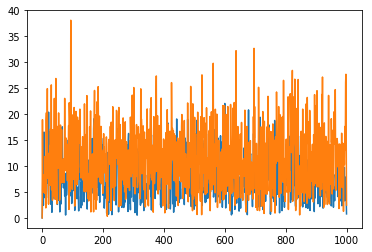

In [12]:
fft1 = abs(np.fft.rfft(sig1))
fft2 = abs(np.fft.rfft(sig2))
plt.plot(fft1)
plt.plot(fft2)

In [13]:
print(np.sum(fft1))
print(np.sum(fft2))
print(np.sum(fft1)/np.sum(fft2))

7992.6826723
11401.576567
0.701015567921


In [14]:
plt.plot(abs(fft_ar_rep))
plt.plot(abs(fft_ar_zero))
out = abs(fft_ar_rep) / abs(fft_ar_zero)

NameError: name 'fft_ar_rep' is not defined

In [14]:
np.sum(abs(fft_ar_rep))

2577716.3193436279

In [15]:
np.sum(abs(fft_ar_zero))

2600289.9400544893

Frequency modifications

In [77]:
fft = np.fft.rfft(ar1)
abs_fft = abs(fft)

Effects of freq resampling

In [82]:
fft = np.fft.rfft(ar1)
fft_rep = np.repeat(fft, 2)

In [84]:
fft_rep[0], fft_rep[1]

((15991.834515167235+0j), (15991.834515167235+0j))

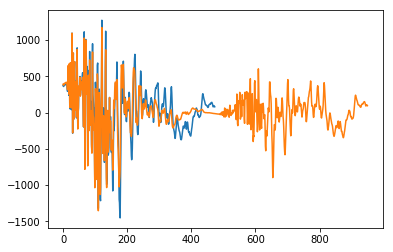

In [88]:
plt.plot(np.fft.irfft(fft))
plt.plot(np.fft.irfft(fft_rep))

In [93]:
import scipy
resamp = scipy.signal.resample(fft, len(fft) * 2)

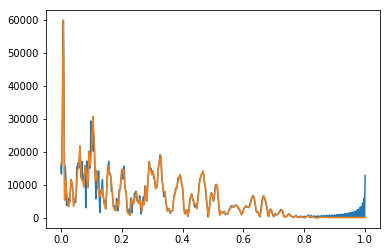

In [97]:
plt.plot(np.linspace(0, 1, len(resamp)), abs(resamp))
plt.plot(np.linspace(0, 1, len(fft)), abs(fft))
         

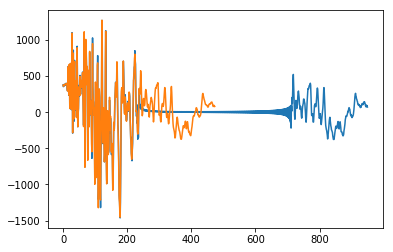

In [100]:
plt.plot(np.fft.irfft(resamp))
plt.plot(np.fft.irfft(fft))